# Spatial map for comparing the timing of extremes 

Note: Data masked by REGEN_ALL (grid points with 80% data availability over 1950-2016) integrated with land_sea_mask from IPCC 

In [1]:
# Import modules
%matplotlib inline
%run /g/data/w40/pn3424/2024/Lisa/Python/Code/Master_functions_Lisa.ipynb
import xarray as xr
import pymannkendall as mk
import fnmatch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Shape of p-values array: (10, 10)


## Define Spatiotemporal boundaries

In [2]:
# Define region of interest (lat and lon boundaries for all of big region of interest e.g. Monsoon Asia, Australia, Africa... )
lat_slice = slice(-25,50)
lon_slice = slice(60,150)

# Define temporal scale for SPI variable (1 for 3-months, 2 for 6-months, 3 for 12-months); use "None" if not using the SPI variable
iscale = None

# Define season as a list of month numbers. If not wanting a seasonal breakdown, use None.
# Suggestions: Wet 6-month: [10,11,12,1,2,3]; Dry 6-month: [4,5,6,7,8,9]; Wet 3-month: [12,1,2]; Dry 3-month: [6,7,8]
season = None
season_name = 'Annual'

# Define mask for regions

mask_ds = xr.open_dataset('/g/data/w40/pn3424/2024/Lisa/mask/land_sea_mask_combined_1degree.nc')

land_mask = mask_ds.sftlf.sel(lat=lat_slice, lon=lon_slice)



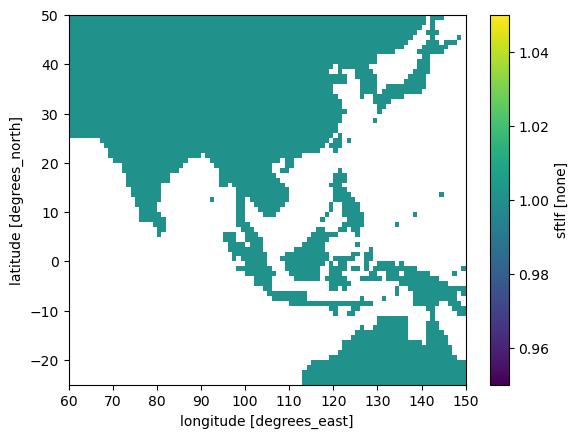

In [3]:
land_mask.plot()

## Define Keywords for Data/Data paths

In [4]:
# Define keywords to be used with f-strings to build the path to datasets
variable = 'mon'

# Define paths to data
global_path = '/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/'


global_data_path = global_path 
regional_data_path = '/g/data/w40/pn3424/2024/Lisa/OBS/timming/obs/time_rx1day_day_APHRODITE-MA.nc'

## Get Pandas Dataframe with complete list of model dataset file paths

In [5]:
data_paths = get_data_files(global_data_path)
pd.set_option('display.max_colwidth', None)
data_paths

,dataset,dataset_path
0,JRA-55,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_JRA-55_mask_modified.nc
1,GIRAFE,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GIRAFE_mask_modified.nc
2,PERSIANN_v1_r1,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_PERSIANN_v1_r1_mask_modified.nc
3,IMERG-v07B-FC,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_IMERG-v07B-FC_mask_modified.nc
4,CHIRPS_v2.0,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_CHIRPS_v2.0_mask_modified.nc
5,REGEN_ALL_2019,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_REGEN_ALL_2019_mask_modified.nc
6,GPCP_V3.2,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GPCP_V3.2_mask_modified.nc
7,GSMAP-NRT-gauges-v8.0,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GSMAP-NRT-gauges-v8.0_mask_modified.nc
8,CMORPH_v1.0_CRT,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_CMORPH_v1.0_CRT_mask_modified.nc
9,ERA5,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_ERA5_mask_modified.nc


### Defining subset

In [6]:
insitu_names = ["CPC_v1.0","GPCC_FDD_v2022","REGEN_ALL_2019"]
satellite_names=["CHIRPS_v2.0","CMORPH_v1.0_CRT","GIRAFE","GPCP_V3.2", "GSMAP-NRT-gauges-v8.0","IMERG-v07B-FC","PERSIANN_v1_r1"]
reanalysis_names=["CFSR","ERA5","JRA-55","MERRA2"]
regional_names='APHRODITE'
#"GIRAFE",

In [7]:
insitu_paths_subset = get_data_files_subset(data_paths, insitu_names).sort_values('data_name')
satellite_paths_subset = get_data_files_subset(data_paths, satellite_names).sort_values('data_name')
reanalysis_paths_subset = get_data_files_subset(data_paths, reanalysis_names).sort_values('data_name')

In [8]:
satellite_paths_subset

,data_name,dataset_path
3,CHIRPS_v2.0,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_CHIRPS_v2.0_mask_modified.nc
6,CMORPH_v1.0_CRT,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_CMORPH_v1.0_CRT_mask_modified.nc
0,GIRAFE,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GIRAFE_mask_modified.nc
4,GPCP_V3.2,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GPCP_V3.2_mask_modified.nc
5,GSMAP-NRT-gauges-v8.0,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_GSMAP-NRT-gauges-v8.0_mask_modified.nc
2,IMERG-v07B-FC,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_IMERG-v07B-FC_mask_modified.nc
1,PERSIANN_v1_r1,/g/data/w40/pn3424/2024/Lisa/OBS/timming/frogs/mask/setc/time_rx1day_day_PERSIANN_v1_r1_mask_modified.nc


## IPCC regional mask and identifying regions of interests according to updated in AR6 IPCC

For definition of regions: please refer  https://regionmask.readthedocs.io/en/stable/defined_scientific.html and https://essd.copernicus.org/articles/12/2959/2020/#&gid=1&pid=1

In [9]:
import regionmask
ipcc_mask_ds=xr.open_dataset("/g/data/w40/pn3424/2024/Lisa/mask/land_sea_mask_combined_1degree.nc")
ipcc_mask=regionmask.defined_regions.ar6.land.mask(ipcc_mask_ds)

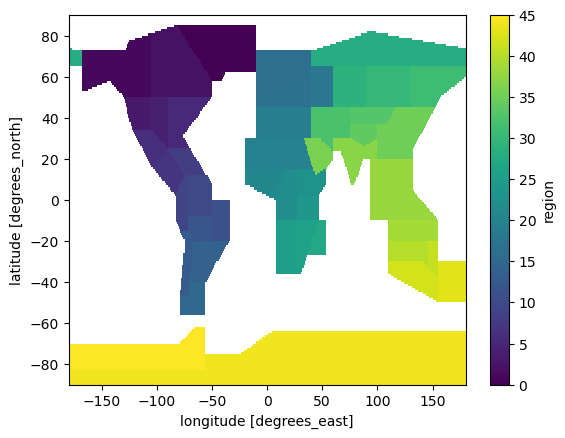

In [10]:
ipcc_mask.plot()

In [11]:
##define IPCC Region
ipcc_subregions = {
    "SEA": 38,
    "EAS": 35,
    "ECA": 33, 
    "TIB": 34, 
    "SAS": 37
}

<GeoAxes: >

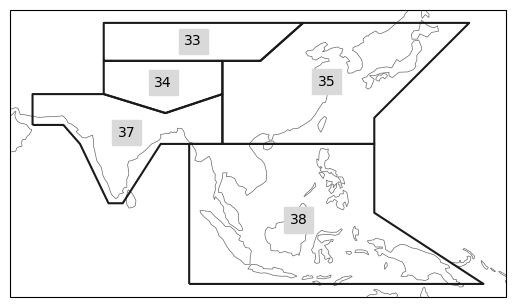

In [12]:
ar6_land=regionmask.defined_regions.ar6.land[['SEA', 'EAS', 'ECA', 'TIB', 'SAS']]
ar6_land.plot()

## Get individual climatology

## for regional dataset

In [13]:
time_slice = slice("2001", "2015")
clim_regional = get_map2(regional_data_path,variable, time_slice, lat_slice, lon_slice, season, iscale, land_mask, ipcc_mask, None)
clim_regional

<xarray.DataArray 'mon' (year: 15, lat: 65, lon: 90)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 3.,  3., 10., ..., nan, nan, nan],
        [ 3.,  3.,  3., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 8.,  8.,  8., ..., nan, nan, nan],
        [ 8.,  8.,  8., ..., nan, nan, nan],
        [ 8.,  8.,  8., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [10., 10., 10., ..., nan, nan, nan],
        [10.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 5.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float32 60.5 61.5 62.5 63.5 64.5 ... 146.5 147.5 148.5 149.5
  * lat      (lat) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 46.5 47.5 48.5 49.5
  * year     (year) int32 2001 2002 2003 2004 2005 ... 2011 2012 2013 2014 2015

## for insitu data

In [14]:
# Intialize an empty dictionary to store model climatologies as DataArrays
clim_insitu = []
rate_inistu = []

# Loop through RCM simulations and calculate the model bias; store in a dictionary
for i, row in insitu_paths_subset.iterrows():
    clim_xr = get_map2(row[1],variable, time_slice, lat_slice, lon_slice, season, iscale, land_mask, ipcc_mask,None)
    common_slices = find_common_slices2(clim_regional, clim_xr)

    regional_ks = get_map2(regional_data_path, variable, time_slice , common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask, ar6_land, None)
    
    insitu_ks = get_map2(row[1], variable, time_slice , common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask, ar6_land, None)
    
    
    
    time=timming_grid2(regional_ks, insitu_ks)
    rate_inistu.append(time)
    
    
    


## for satellite data

In [15]:
# Intialize an empty dictionary to store model climatologies as DataArrays
clim_sate = []
rate_sate = []


# Loop through RCM simulations and calculate the model bias; store in a dictionary
for i, row in satellite_paths_subset.iterrows():
    if (i==0):
        time_slice1 = slice("2002", "2015")
    else: 
        time_slice1 = slice("2001", "2015")
        
    clim_xr = get_map2(row[1],variable, time_slice1, lat_slice, lon_slice, season, iscale, land_mask, None)
    common_slices = find_common_slices2(clim_regional, clim_xr)
    
 
    regional_ks = get_map2(regional_data_path, variable,time_slice1, common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask,None)
    sate_ks = get_map2(row[1], variable, time_slice1, common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask, None)
    
    time=timming_grid2(regional_ks, sate_ks)
    rate_sate.append(time)
    
    
   

In [16]:
regional_ks

<xarray.DataArray 'mon' (year: 15, lat: 65, lon: 90)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 3.,  3., 10., ..., nan, nan, nan],
        [ 3.,  3.,  3., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 8.,  8.,  8., ..., nan, nan, nan],
        [ 8.,  8.,  8., ..., nan, nan, nan],
        [ 8.,  8.,  8., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [10., 10., 10., ..., nan, nan, nan],
        [10.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 5.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan],
        [ 5.,  5.,  5., ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float32 60.5 61.5 62.5 63.5 64.5 ... 146.5 147.5 148.5 149.5
  * lat      (lat) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 46.5 47.5 48.5 49.5
  * year     (year) int32 2001 2002 2003 2004 2005 ... 2011 2012 2013 2014 2015

In [17]:
sate_ks

<xarray.DataArray 'mon' (year: 15, lat: 65, lon: 90)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [11., 11.,  1., ..., nan, nan, nan],
        [11., 11., 10., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4.,  4., ..., nan, nan, nan],
        [ 4.,  4., 12., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 3.,  2.,  2., ..., nan, nan, nan],
        [ 3.,  2.,  2., ..., nan, nan, nan],
        [ 3.,  2.,  2., ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [11.,  2.,  2., ..., nan, nan, nan],
        [ 5.,  2.,  2., ..., nan, nan, nan],
        [12., 12., 11., ..., nan, nan, nan]]])
Coordinates:
  * lon      (lon) float64 60.5 61.5 62.5 63.5 64.5 ... 146.5 147.5 148.5 149.5
  * lat      (lat) float64 -14.5 -13.5 -12.5 -11.5 -10.5 ... 46.5 47.5 48.5 49.5
  * year     (year) int64 2001 2002 2003 2004 2005 ... 2011 2012 2013 2014 2015

## for reanalysis data

In [18]:
# Intialize an empty dictionary to store model climatologies as DataArrays
clim_reanalysis = []
rate_rea = []


# Loop through RCM simulations and calculate the model bias; store in a dictionary
for i, row in reanalysis_paths_subset.iterrows():
    clim_xr = get_map2(row[1],variable, time_slice, lat_slice, lon_slice, season, iscale, land_mask, ipcc_mask,None)
    common_slices = find_common_slices2(clim_regional, clim_xr)

    regional_ks = get_map2(regional_data_path, variable, time_slice , common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask, ar6_land, None)
    
    rea_ks = get_map2(row[1], variable, time_slice , common_slices['lat_slice'], common_slices['lon_slice'], season, iscale, land_mask, ar6_land, None)
    
    
    
    time=timming_grid2(regional_ks, rea_ks)
    rate_rea.append(time)
    

In [19]:
## combined all climatology map into one array 
all_climatology= [*rate_inistu,rate_inistu[0], *rate_sate,rate_sate[0], *rate_rea]
#all_climatology

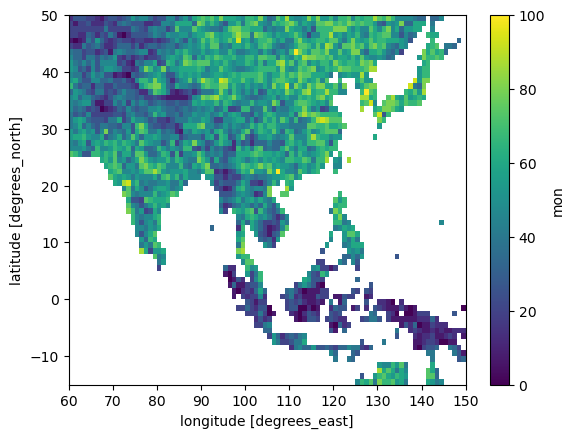

In [20]:
#all_climatology[0].plot()
all_climatology[0].plot()

## Plot spatial map

In [21]:
#extent=[lonmin1, lonmax1, latmin1, latmax1]
extent = [60, 150, -15, 50]
proj = ccrs.PlateCarree()

# Axes indices where I want lat and/or lon tickmarks on the map
lat_label = [0, 4,8]
lon_label = [13,14,15]
both_label = [12]

# Lat/Lon values to show for axis labels
lat_ticks = [-15,0,15,30,45]
lon_ticks = [65,95,125]

# Define colormap
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

#norm = colors.BoundaryNorm([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 10)
#cmap = ListedColormap(["#fff7fb", "#eee4f1", "#d6d5e8", "#b4c4df", "#83b2d4", "#519ec8", 
#                        "#258bae", "#027c7f", "#016855", "#014636"])

cmap = ListedColormap(plt.cm.GnBu(np.linspace(0, 1, 10)))
norm = colors.BoundaryNorm(np.linspace(0, 100, 11), 10)


### Create Sorted Panel Plot - Portrait (for Paper)

In [22]:
text=['(a)','(b)','(c)','c','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(j)','(k)','(l)','(m)','(n)','o']

In [23]:
##name of datasets
Name=[*insitu_names,insitu_names[0], *satellite_names, satellite_names[0], *reanalysis_names]

/jobfs/133556437.gadi-pbs/ipykernel_379615/2377039630.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


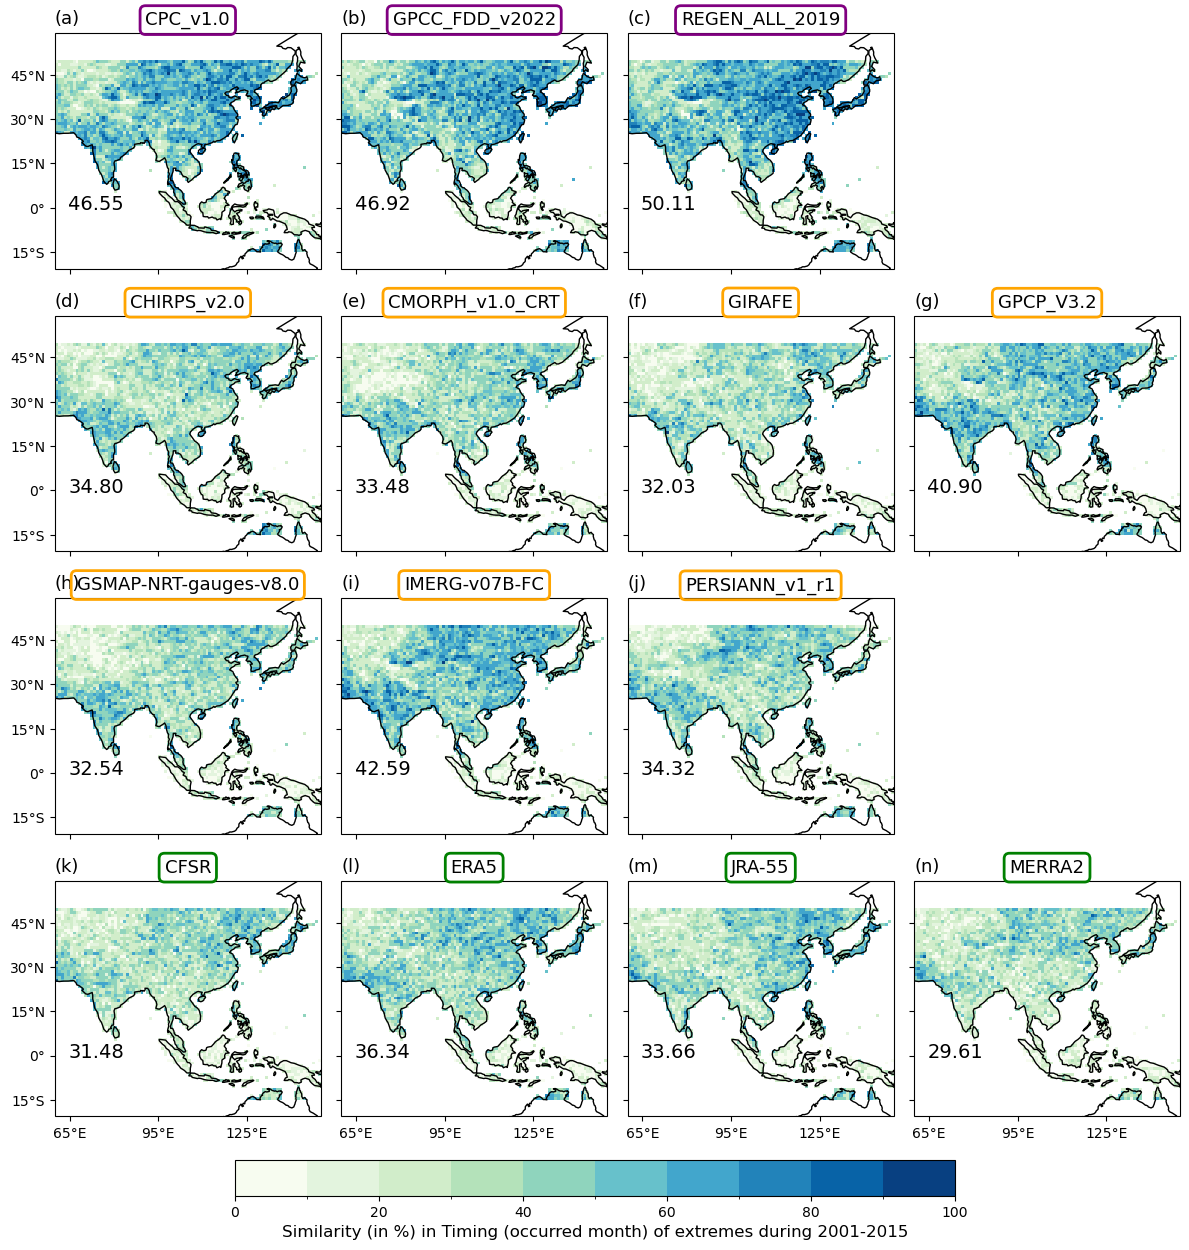

In [24]:
# Define figure size
fig = plt.figure(figsize=(12,12))

#fig.text(0.5, 0.999, f"Map plots of {variable} over {region_name} in the updated SREX regions in the sixth IPCC assessment report (AR6)", ha='center', wrap=True, fontsize=16)

# Setup axes for all subplots
gs = gridspec.GridSpec(5,4,height_ratios=[1,1,1,1,0.1],width_ratios=[1,1,1,1])

row_max = 4
col_max = 3
row = 0
col = 0

# Set up Axes labels (this loops through the sorted Pandas DF to assign axes positions based on wetness)
# For Models
plot = {} 
mean = {}
for i in range(len(all_climatology)):
    ax = fig.add_subplot(gs[row,col], projection=proj)
    
    if col == col_max:
        row = row + 1
        col = 0 
    else:
        col = col + 1
    
    
    plot[Name[i]]=all_climatology[i].where(land_mask==1).plot(ax=ax, add_labels=False, add_colorbar=False, cmap=cmap, norm=norm)
    mean[i]=all_climatology[i].mean(dim= ('lon','lat'))
    
    

for i, ax in enumerate(fig.axes):
    ax.text(0.05, 0.25, '%.2f' % mean[i].values, fontsize=14, transform=ax.transAxes)
##title name: 
    
    if (i<=3):
        ax.set_title(Name[i], fontsize=13, bbox=dict(facecolor='none', edgecolor='purple',boxstyle='round', lw=2))
    if ((i>3) and (i<12)): 
        ax.set_title(Name[i],fontsize=13, bbox=dict(facecolor='none', edgecolor='orange',boxstyle='round',lw=2))
    if (i>=12): 
        ax.set_title(Name[i],fontsize=13, bbox=dict(facecolor='none', edgecolor='green',boxstyle='round',lw=2))
        
    ax.text(0, 1.1, text[i], fontsize=13, transform=ax.transAxes, color='black', va='top')
   

##display coastal line 
    ax.coastlines()
    ax.set_extent(extent)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    if i in (3,11):
        ax.set_visible(False)
        
    if i in lat_label:
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
    elif i in lon_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    elif i in both_label:
        ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
    else:
        continue


# Plot colorbars
cbar_gs = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=gs[4,:], hspace=0.7)
cbar_ax = fig.add_axes([0.2, 0.0, 0.6, 0.03])
#cbar_ax = fig.add_subplot(cbar_gs[0,0])
plt.colorbar(plot['CPC_v1.0'], cbar_ax, orientation='horizontal', extend=None)
cbar_ax.set_xlabel(f"Similarity (in %) in Timing (occurred month) of extremes during 2001-2015",fontsize=12.0)

# Plot with tight layout
plt.tight_layout()
plt.savefig("/g/data/w40/pn3424/2024/Lisa/Fig/Jan2025/Timming_MA_spatial_pattern.png",dpi=300,bbox_inches='tight')



In [25]:
values = [round(data.item(), 2) for data in mean.values()]
print(values)

[46.55, 46.92, 50.11, 46.55, 34.8, 33.48, 32.03, 40.9, 32.54, 42.59, 34.32, 34.8, 31.48, 36.34, 33.66, 29.61]
